# Spontaneous Emission and Photoluminescence in Quantum Wires

:::{abstract}
This example demonstrates how to calculate spontaneous emission rates and photoluminescence spectra for quantum wire systems using the `pulsesuite.PSTD3D.emission` module. We investigate radiative recombination processes, many-body Coulomb corrections, and temperature-dependent emission spectra.
:::

## Theory

The emission module calculates spontaneous emission and photoluminescence (PL) from quantum wires. Spontaneous emission occurs when electron-hole pairs recombine radiatively, emitting photons.

### Spontaneous Emission Rate

The spontaneous emission rate $R_{sp}(k)$ for a momentum state $k$ is given by:

$$
R_{sp}(k) = \int_0^{\infty} d(\hbar\omega) \, (\hbar\omega + E_k) \, \rho_0(\hbar\omega + E_k) \, W(\hbar\omega)
$$

where $E_k$ is the transition energy including many-body corrections, $\rho_0$ is the photon density of states, and $W$ is the emission probability.

### Transition Energy

The transition energy includes Coulomb many-body corrections:

$$
E_k = E_{gap} + E_e(k) + E_h(k) + E_c(k)
$$

where $E_c(k)$ is the Coulomb energy correction due to electron-electron, hole-hole, and electron-hole interactions.

### Photon Density of States

The photon density of states in free space is:

$$
\rho_0(\hbar\omega) = \frac{(\hbar\omega)^2}{\pi^2 c^3 \hbar^3}
$$

### Photoluminescence Spectrum

The PL spectrum $PLS(\hbar\omega)$ accounts for carrier distributions, thermal broadening, and dephasing:

$$
PLS(\hbar\omega) = R_{scale} \sum_k n_e(k) n_h(k) \, \hbar\omega \, \rho_0(\hbar\omega) \,
\exp\left(-\frac{|\hbar\omega - E_k|}{k_B T_{avg}}\right) \,
L(\hbar\omega - E_k, \hbar\gamma_{eh})
$$

where $L$ is a Lorentzian lineshape, $T_{avg}$ is the average carrier temperature, and $\gamma_{eh}$ is the electron-hole dephasing rate.

## Setup and Initialization

First, we import the necessary modules and set up the physical parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pulsesuite.PSTD3D import emission
from scipy.constants import e as e0, hbar, k as kB

# Physical Parameters for GaAs Quantum Wire
L_wire = 200e-9          # Wire length (m)
N_k = 128                # Momentum grid points
m_e = 0.067 * 9.109e-31  # Electron effective mass (kg)
m_h = 0.45 * 9.109e-31   # Hole effective mass (kg)
gap = 1.5 * e0           # Band gap energy (J)
dcv = 1.0e-29            # Dipole matrix element (C·m)
epsr = 12.0              # Relative dielectric constant
geh = 1e12               # Electron-hole dephasing rate (Hz)
ehint = 0.8              # Electron-hole interaction strength
Temp = 77.0              # Temperature (K)

# Initialize Momentum Grid
k_grid = np.linspace(-5e8, 5e8, N_k)  # Momentum grid (1/m)
dk = k_grid[1] - k_grid[0]

# Single-particle energies
E_e = hbar**2 * k_grid**2 / (2 * m_e)
E_h = hbar**2 * k_grid**2 / (2 * m_h)

print(f"Momentum grid: {k_grid.min():.2e} to {k_grid.max():.2e} m^-1")
print(f"Band gap: {gap/e0*1e3:.1f} meV")
print(f"Temperature: {Temp} K")

ModuleNotFoundError: No module named 'libpulsesuite'

## Initialize Emission Module

We initialize the emission module, which sets up internal arrays and pre-calculates integration parameters.

In [2]:
# Initialize Emission Module
emission.InitializeEmission(k_grid, E_e, E_h, dcv, epsr, geh, ehint)

print("Emission module initialized")
print(f"RScale factor: {emission._RScale:.2e}")

NameError: name 'emission' is not defined

:::{note}
The `InitializeEmission` function sets up:
- The `_idel` matrix (1 - identity) for Coulomb calculations
- The `_RScale` factor for emission rate scaling
- The `_HOmega` array for numerical integration
- The `_square` array for pre-calculated emission integrals
:::

## Initial Carrier Distributions

We create initial carrier distributions for electrons and holes. These represent excited carriers that can recombine radiatively.

In [3]:
# Initial Electron Distribution (Gaussian centered at k=0)
sigma_k = 1e8
n_e = np.exp(-k_grid**2 / (2 * sigma_k**2)) + 0j
n_e /= np.sum(n_e)  # Normalize

# Initial Hole Distribution
n_h = np.exp(-k_grid**2 / (2 * sigma_k**2)) + 0j
n_h /= np.sum(n_h)  # Normalize

# Coulomb interaction matrices (simplified - constant for this demo)
N_k = len(k_grid)
VC = np.zeros((N_k, N_k, 3))
# For realistic simulations, these would be calculated from Coulomb module
VC[:, :, 0] = np.eye(N_k) * 1e-20  # Electron-hole (simplified)
VC[:, :, 1] = np.eye(N_k) * 1e-20  # Electron-electron (simplified)
VC[:, :, 2] = np.eye(N_k) * 1e-20  # Hole-hole (simplified)

print(f"Initial electron density: {np.sum(np.real(n_e)):.4f}")
print(f"Initial hole density: {np.sum(np.real(n_h)):.4f}")

NameError: name 'k_grid' is not defined

## Coulomb Energy Correction

The Coulomb energy correction accounts for many-body effects on transition energies.

In [4]:
# Calculate Coulomb energy correction
Ec_correction = emission.Ec(np.real(n_e), np.real(n_h), VC)

# Transition energies with and without Coulomb correction
E_transition = gap + E_e + E_h
E_transition_corrected = gap + E_e + E_h + Ec_correction

print(f"Coulomb correction range: {Ec_correction.min()/e0*1e3:.3f} to {Ec_correction.max()/e0*1e3:.3f} meV")
print(f"Transition energy range (no correction): {E_transition.min()/e0*1e3:.1f} to {E_transition.max()/e0*1e3:.1f} meV")
print(f"Transition energy range (with correction): {E_transition_corrected.min()/e0*1e3:.1f} to {E_transition_corrected.max()/e0*1e3:.1f} meV")

NameError: name 'emission' is not defined

## Spontaneous Emission Rates

We calculate the spontaneous emission rate for each momentum state.

In [5]:
# Calculate spontaneous emission rates
Rsp = np.zeros(N_k)

emission.SpontEmission(n_e, n_h, E_e, E_h, gap, geh, VC, Rsp)

print(f"Spontaneous emission rate range: {Rsp.min():.2e} to {Rsp.max():.2e} s^-1")
print(f"Total emission rate: {np.sum(Rsp):.2e} s^-1")

NameError: name 'N_k' is not defined

## Photon Density of States

The photon density of states determines the available photon modes for emission.

In [6]:
# Calculate photon density of states for a range of energies
hw_range = np.linspace(gap * 0.9, gap * 1.2, 100)
rho_photon = emission.rho0(hw_range)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(hw_range/e0*1e3, rho_photon, 'b-', linewidth=2)
ax.set_xlabel('Photon Energy (meV)')
ax.set_ylabel('Photon Density of States (1/(J·m³))')
ax.set_title('Photon Density of States')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'gap' is not defined

## Photoluminescence Spectrum

We calculate the full photoluminescence spectrum as a function of photon energy.

In [7]:
# Set up photon energy array for PL spectrum
N_w = 200  # Number of energy points
hw_PL = np.zeros(N_w)
PLS = np.zeros(N_w)

# Energy range for PL spectrum (around band gap)
E_start = gap * 0.95
E_max = gap * 1.15

emission.Calchw(hw_PL, PLS, E_start, E_max)

# Calculate PL spectrum at time t = 0
t = 0.0
emission.PLSpectrum(n_e, n_h, E_e, E_h, gap, geh, VC, hw_PL, t, PLS)

print(f"PL spectrum calculated")
print(f"Peak PL intensity: {np.max(PLS):.2e}")
print(f"Peak energy: {hw_PL[np.argmax(PLS)]/e0*1e3:.1f} meV")

NameError: name 'gap' is not defined

## Visualization

We visualize the carrier distributions, emission rates, and PL spectrum.

NameError: name 'k_grid' is not defined

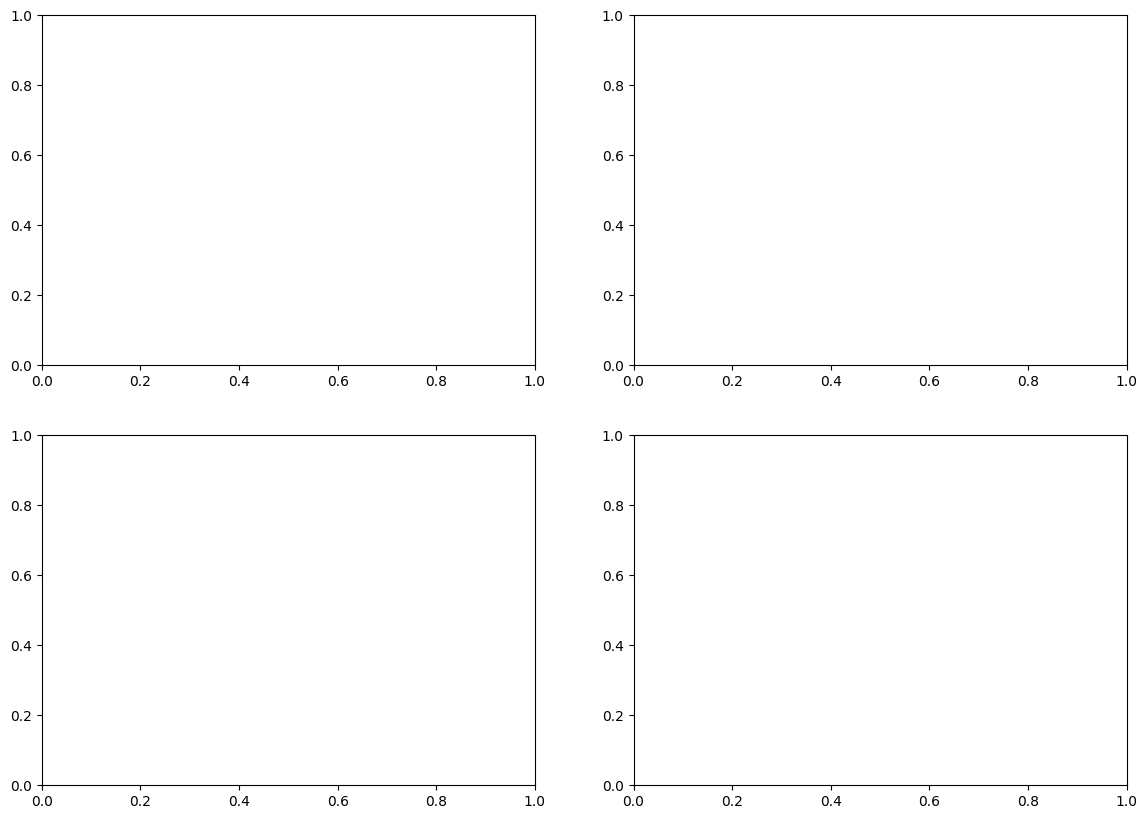

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Carrier distributions
ax = axes[0, 0]
ax.plot(k_grid/1e8, np.real(n_e), 'b-', label='$n_e(k)$', linewidth=2)
ax.plot(k_grid/1e8, np.real(n_h), 'g-', label='$n_h(k)$', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Occupation')
ax.set_title('Carrier Distributions')
ax.grid(True, alpha=0.3)
ax.legend()

# Spontaneous emission rates
ax = axes[0, 1]
ax.plot(k_grid/1e8, Rsp, 'r-', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Emission Rate (s$^{-1}$)')
ax.set_title('Spontaneous Emission Rates')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Transition energies
ax = axes[1, 0]
ax.plot(k_grid/1e8, E_transition/e0*1e3, 'b--', label='Without Coulomb', linewidth=2)
ax.plot(k_grid/1e8, E_transition_corrected/e0*1e3, 'r-', label='With Coulomb', linewidth=2)
ax.set_xlabel('Wavevector ($10^8$ m$^{-1}$)')
ax.set_ylabel('Transition Energy (meV)')
ax.set_title('Transition Energies')
ax.grid(True, alpha=0.3)
ax.legend()

# Photoluminescence spectrum
ax = axes[1, 1]
ax.plot(hw_PL/e0*1e3, PLS, 'purple', linewidth=2)
ax.set_xlabel('Photon Energy (meV)')
ax.set_ylabel('PL Intensity (arb. u.)')
ax.set_title('Photoluminescence Spectrum')
ax.grid(True, alpha=0.3)
ax.axvline(gap/e0*1e3, color='k', linestyle='--', alpha=0.5, label='Band Gap')
ax.legend()

plt.tight_layout()
plt.show()

:::{note}
The PL spectrum shows a peak near the band gap energy. The width and shape depend on:
- Carrier temperature (thermal broadening)
- Dephasing rate (Lorentzian broadening)
- Coulomb interactions (energy renormalization)
- Carrier distributions (occupation factors)
:::

## Temperature Dependence

We investigate how the PL spectrum changes with temperature by modifying the temperature parameter.

NameError: name 'emission' is not defined

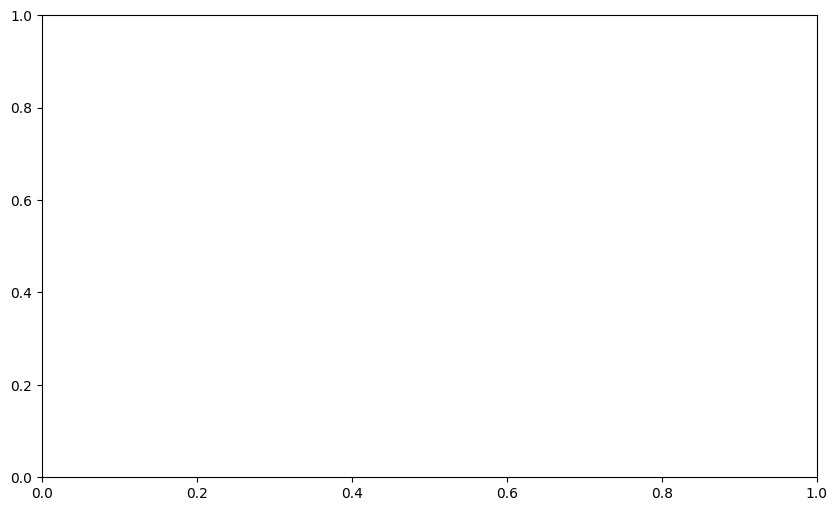

In [9]:
# Calculate PL spectra at different temperatures
temperatures = [10.0, 77.0, 150.0, 300.0]
colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(10, 6))

for T, color in zip(temperatures, colors):
    # Update temperature (this would normally be done through InitializeEmission)
    # For this demo, we'll recalculate with different thermal factors
    emission._Temp = T

    # Re-initialize to update temperature-dependent arrays
    emission.InitializeEmission(k_grid, E_e, E_h, dcv, epsr, geh, ehint)

    # Recalculate PL spectrum
    PLS_T = np.zeros(N_w)
    emission.Calchw(hw_PL, PLS_T, E_start, E_max)
    emission.PLSpectrum(n_e, n_h, E_e, E_h, gap, geh, VC, hw_PL, t, PLS_T)

    # Normalize for comparison
    PLS_T = PLS_T / np.max(PLS_T) if np.max(PLS_T) > 0 else PLS_T

    ax.plot(hw_PL/e0*1e3, PLS_T, color=color, linewidth=2, label=f'T = {T} K')

ax.set_xlabel('Photon Energy (meV)')
ax.set_ylabel('Normalized PL Intensity')
ax.set_title('Temperature-Dependent Photoluminescence')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

:::{tip}
At higher temperatures, the PL spectrum broadens due to increased thermal energy. The peak may also shift slightly due to temperature-dependent band gap renormalization.
:::

## Time Evolution of PL

We can track how the PL spectrum evolves in time as carriers recombine.

NameError: name 'emission' is not defined

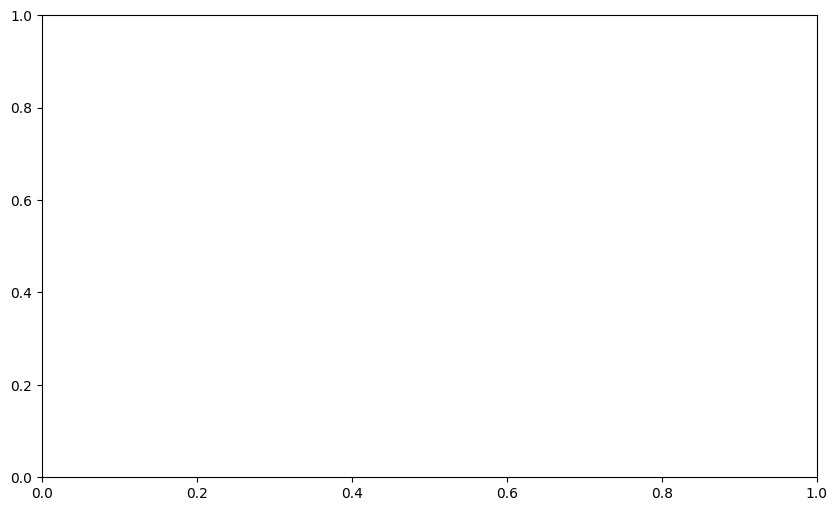

In [10]:
# Simulate time evolution (simplified - in real simulations, carriers would evolve)
times = [0.0, 1e-12, 5e-12, 10e-12]  # Time points (s)
colors = ['blue', 'green', 'orange', 'red']

fig, ax = plt.subplots(figsize=(10, 6))

for t_val, color in zip(times, colors):
    # For this demo, we'll use the same distributions but different times
    # In real simulations, n_e and n_h would evolve according to SBEs
    PLS_t = np.zeros(N_w)
    emission.Calchw(hw_PL, PLS_t, E_start, E_max)
    emission.PLSpectrum(n_e, n_h, E_e, E_h, gap, geh, VC, hw_PL, t_val, PLS_t)

    # Normalize for comparison
    PLS_t = PLS_t / np.max(PLS_t) if np.max(PLS_t) > 0 else PLS_t

    ax.plot(hw_PL/e0*1e3, PLS_t, color=color, linewidth=2,
            label=f't = {t_val*1e12:.1f} ps')

ax.set_xlabel('Photon Energy (meV)')
ax.set_ylabel('Normalized PL Intensity')
ax.set_title('Time Evolution of Photoluminescence')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

## Spontaneous Emission Integral

The spontaneous emission integral is calculated numerically using pre-computed arrays. Let's examine how it depends on transition energy.

In [11]:
# Calculate spontaneous emission integral for different transition energies
E_test = np.linspace(gap * 0.9, gap * 1.1, 50)
Rsp_integral = np.zeros(len(E_test))

for i, E_val in enumerate(E_test):
    Rsp_integral[i] = emission.SpontIntegral(E_val)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(E_test/e0*1e3, Rsp_integral, 'b-', linewidth=2)
ax.set_xlabel('Transition Energy (meV)')
ax.set_ylabel('Spontaneous Emission Integral')
ax.set_title('Emission Integral vs Transition Energy')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'gap' is not defined

## Summary

This example demonstrated:

1. **Initialization** of the emission module with physical parameters
2. **Coulomb energy corrections** accounting for many-body effects
3. **Spontaneous emission rates** calculation for each momentum state
4. **Photoluminescence spectrum** as a function of photon energy
5. **Temperature dependence** of PL spectra
6. **Time evolution** of emission processes
7. **Photon density of states** and its role in emission

The `emission` module provides a comprehensive framework for calculating radiative recombination processes in quantum wires, including spontaneous emission and photoluminescence with many-body Coulomb corrections and thermal effects.